In [113]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [114]:
import tensorflow as tf
import pandas as pd
from PIL import Image
import numpy as np
import zipfile
import os
import glob
import random
import sys

import skimage.io  #Used for imshow function
import skimage.transform  #Used for resize function
from skimage.morphology import label  #Used for Run-Length-Encoding RLE to create final submission
import matplotlib.pyplot as plt

from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [115]:
# Загрузка данных
data_dir = 'data_256/'
images_dir = 'images/'
masks_dir = 'masks/'
WIDTH = 256
HEIGHT = 256
CLASSES = 1

In [116]:
import os
from PIL import Image
import numpy as np


def load_image(image_path):
    image = Image.open(data_dir + images_dir + image_path)  #.convert('L')  # Преобразуем в оттенки серого
    return np.array(image)


import numpy as np
from PIL import Image

def load_mask(mask_path):
    mask = Image.open(data_dir + masks_dir + mask_path).convert('L')  # Преобразуем в оттенки серого
    mask_array = np.array(mask)
    mask_float = mask_array.astype(float) / 255.0  # Преобразуем в тип float и нормализуем значения до диапазона [0, 1]
    return mask_float


In [117]:
# # Подготовка данных
image_paths = sorted(os.listdir(data_dir + images_dir))

In [118]:
print(image_paths)

['1.png', '10.png', '100.png', '101.png', '102.png', '103.png', '104.png', '105.png', '106.png', '107.png', '108.png', '109.png', '11.png', '110.png', '111.png', '112.png', '113.png', '114.png', '115.png', '116.png', '117.png', '118.png', '119.png', '12.png', '120.png', '121.png', '122.png', '123.png', '124.png', '125.png', '126.png', '127.png', '128.png', '129.png', '13.png', '130.png', '131.png', '132.png', '133.png', '134.png', '135.png', '136.png', '137.png', '138.png', '139.png', '14.png', '140.png', '141.png', '142.png', '143.png', '144.png', '145.png', '146.png', '147.png', '148.png', '149.png', '15.png', '150.png', '151.png', '152.png', '153.png', '154.png', '155.png', '156.png', '157.png', '158.png', '159.png', '16.png', '160.png', '161.png', '162.png', '163.png', '164.png', '165.png', '166.png', '167.png', '168.png', '169.png', '17.png', '170.png', '171.png', '172.png', '173.png', '174.png', '175.png', '176.png', '177.png', '178.png', '179.png', '18.png', '180.png', '181.png'

In [119]:
from sklearn.model_selection import train_test_split

# Разделение данных на обучающую, валидационную и тестовую выборки
train_paths, test_paths = train_test_split(image_paths, test_size=0.2, random_state=42)
train_paths, valid_paths = train_test_split(train_paths, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

# Проверка размеров выборок
print("Train samples:", len(train_paths))
print("Valid samples:", len(valid_paths))
print("Test samples:", len(test_paths))

Train samples: 358
Valid samples: 120
Test samples: 120


In [120]:
train_images = [load_image(image_path) for image_path in train_paths]
train_masks = [load_mask(mask_path) for mask_path in train_paths]
train_images = np.array(train_images)
train_masks = np.array(train_masks)

In [121]:
valid_images = [load_image(image_path) for image_path in valid_paths]
valid_masks = [load_mask(mask_path) for mask_path in valid_paths]
valid_images = np.array(valid_images)
valid_masks = np.array(valid_masks)

In [122]:
test_images = [load_image(image_path) for image_path in test_paths]
test_masks = [load_mask(mask_path) for mask_path in test_paths]
test_images = np.array(test_images)
test_masks = np.array(test_masks)

In [123]:

def unet_test_model(classes: int = 1):
    tf.keras.backend.clear_session()
    nb_filter = [32, 64, 128, 256, 512]
    # Build U-Net++ model
    inputs = Input((WIDTH, HEIGHT, 3))
    s = Lambda(lambda x: x / 255)(inputs)

    c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.5)(c1)
    c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c1)
    c1 = Dropout(0.5)(c1)
    p1 = MaxPooling2D((2, 2), strides=(2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.5)(c2)
    c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c2)
    c2 = Dropout(0.5)(c2)
    p2 = MaxPooling2D((2, 2), strides=(2, 2))(c2)

    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(c2)
    conv1_2 = concatenate([up1_2, c1], name='merge12', axis=3)
    c3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv1_2)
    c3 = Dropout(0.5)(c3)
    c3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c3)
    c3 = Dropout(0.5)(c3)

    conv3_1 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p2)
    conv3_1 = Dropout(0.5)(conv3_1)
    conv3_1 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv3_1)
    conv3_1 = Dropout(0.5)(conv3_1)
    pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, c2], name='merge22', axis=3)  #x10
    conv2_2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv2_2)
    conv2_2 = Dropout(0.5)(conv2_2)
    conv2_2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv2_2)
    conv2_2 = Dropout(0.5)(conv2_2)

    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, c1, c3], name='merge13', axis=3)
    conv1_3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv1_3)
    conv1_3 = Dropout(0.5)(conv1_3)
    conv1_3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv1_3)
    conv1_3 = Dropout(0.5)(conv1_3)

    conv4_1 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(pool3)
    conv4_1 = Dropout(0.5)(conv4_1)
    conv4_1 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv4_1)
    conv4_1 = Dropout(0.5)(conv4_1)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=3)  #x20
    conv3_2 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv3_2)
    conv3_2 = Dropout(0.5)(conv3_2)
    conv3_2 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv3_2)
    conv3_2 = Dropout(0.5)(conv3_2)

    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, c2, conv2_2], name='merge23', axis=3)
    conv2_3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv2_3)
    conv2_3 = Dropout(0.5)(conv2_3)
    conv2_3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv2_3)
    conv2_3 = Dropout(0.5)(conv2_3)

    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, c1, c3, conv1_3], name='merge14', axis=3)
    conv1_4 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv1_4)
    conv1_4 = Dropout(0.5)(conv1_4)
    conv1_4 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv1_4)
    conv1_4 = Dropout(0.5)(conv1_4)

    conv5_1 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(pool4)
    conv5_1 = Dropout(0.5)(conv5_1)
    conv5_1 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv5_1)
    conv5_1 = Dropout(0.5)(conv5_1)

    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=3)  #x30
    conv4_2 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv4_2)
    conv4_2 = Dropout(0.5)(conv4_2)
    conv4_2 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv4_2)
    conv4_2 = Dropout(0.5)(conv4_2)

    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=3)
    conv3_3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv3_3)
    conv3_3 = Dropout(0.5)(conv3_3)
    conv3_3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv3_3)
    conv3_3 = Dropout(0.5)(conv3_3)

    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, c2, conv2_2, conv2_3], name='merge24', axis=3)
    conv2_4 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv2_4)
    conv2_4 = Dropout(0.5)(conv2_4)
    conv2_4 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv2_4)
    conv2_4 = Dropout(0.5)(conv2_4)

    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, c1, c3, conv1_3, conv1_4], name='merge15', axis=3)
    conv1_5 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv1_5)
    conv1_5 = Dropout(0.5)(conv1_5)
    conv1_5 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv1_5)
    conv1_5 = Dropout(0.5)(conv1_5)

    nestnet_output_4 = Conv2D(classes, (1, 1), activation='sigmoid', kernel_initializer='he_normal', name='output_4',
                              padding='same')(conv1_5)
    # output = Conv2D(
    #     filters=classes,
    #     kernel_size=(3, 3),
    #     padding='same',
    #     activation='softmax',
    #     use_bias=True,
    #     kernel_initializer='glorot_uniform',
    #     name='final_conv',
    # )(nestnet_output_4)

    # create keras model instance
    return Model(inputs=[inputs], outputs=
    [nestnet_output_4])


In [124]:
LR = 0.0001


def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def bce_dice_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

In [125]:
import numpy as np

# Assuming you have a NumPy array called `arr` with shape [?, 256, 256]
arr = np.random.random([2, 3, 4])  # Example array

# Reshape the array to [?, 3, 4, 1]
reshaped_arr = np.reshape(arr, (arr.shape[0], arr.shape[1], arr.shape[2], 1))
print(arr)
print(reshaped_arr)

[[[0.74543064 0.22634383 0.98927551 0.34800355]
  [0.86158893 0.65941974 0.65140386 0.56489983]
  [0.31222949 0.51311137 0.99695962 0.19563963]]

 [[0.01434721 0.47676942 0.75012462 0.47053108]
  [0.6465039  0.60908979 0.43289791 0.75904716]
  [0.98243139 0.26966165 0.87300977 0.63899997]]]
[[[[0.74543064]
   [0.22634383]
   [0.98927551]
   [0.34800355]]

  [[0.86158893]
   [0.65941974]
   [0.65140386]
   [0.56489983]]

  [[0.31222949]
   [0.51311137]
   [0.99695962]
   [0.19563963]]]


 [[[0.01434721]
   [0.47676942]
   [0.75012462]
   [0.47053108]]

  [[0.6465039 ]
   [0.60908979]
   [0.43289791]
   [0.75904716]]

  [[0.98243139]
   [0.26966165]
   [0.87300977]
   [0.63899997]]]]


In [126]:
from keras.losses import binary_crossentropy
import keras.backend as K


def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score


def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss


def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss


def weighted_dice_coeff(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight * weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    return score


def weighted_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd number
    if K.int_shape(y_pred)[1] == 128:
        kernel_size = 11
    elif K.int_shape(y_pred)[1] == 256:
        kernel_size = 21
    elif K.int_shape(y_pred)[1] == 512:
        kernel_size = 21
    elif K.int_shape(y_pred)[1] == 1024:
        kernel_size = 41
    else:
        raise ValueError('Unexpected image size')
    print(kernel_size)
    averaged_mask = K.pool2d(
        y_true, pool_size=(kernel_size, kernel_size), strides=(1, 1), padding='same', pool_mode='avg')
    border = K.cast(K.greater(averaged_mask, 0.005), 'float32') * K.cast(K.less(averaged_mask, 0.995), 'float32')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight += border * 2
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = 1 - weighted_dice_coeff(y_true, y_pred, weight)
    return loss


def weighted_bce_loss(y_true, y_pred, weight=0.5):
    # avoiding overflow
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))

    # https://www.tensorflow.org/api_docs/python/tf/nn/weighted_cross_entropy_with_logits
    loss = (1. - y_true) * logit_y_pred + (1. + (weight - 1.) * y_true) * \
           (K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)


import tensorflow.keras.backend as K

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # Expand dimensions of y_true and y_pred
    y_true = K.expand_dims(y_true, axis=-1)
    y_pred = K.expand_dims(y_pred, axis=-1)

    # Остальной код функции...
    if K.int_shape(y_pred)[1] == 128:
        kernel_size = 11
    elif K.int_shape(y_pred)[1] == 256:
        kernel_size = 21
    elif K.int_shape(y_pred)[1] == 512:
        kernel_size = 21
    elif K.int_shape(y_pred)[1] == 1024:
        kernel_size = 41
    else:
        raise ValueError('Unexpected image size')
    averaged_mask = K.pool2d(
        y_true, pool_size=(kernel_size, kernel_size), strides=(1, 1), padding='same', pool_mode='avg')

    border = K.cast(K.greater(averaged_mask, 0.005), 'float32') * K.cast(K.less(averaged_mask, 0.995), 'float32')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight += border * 2
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + (1 - weighted_dice_coeff(y_true, y_pred, weight))
    return loss

In [127]:
import tensorflow as tf

# Определение метрики IoU
def iou(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou_score = intersection / (union + tf.keras.backend.epsilon())
    return iou_score

# Определение метрики Pixel Accuracy
def pixel_accuracy(y_true, y_pred):
    return tf.reduce_mean(tf.cast(tf.equal(y_true, tf.round(y_pred)), tf.float32))

# Определение метрики Dice Score
def dice_score(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    dice = (2.0 * intersection) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + tf.keras.backend.epsilon())
    return dice

# Создание списка обратных вызовов с метриками
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(filepath='model.h5', save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=3),
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
    tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: print(f"IoU: {logs['iou']} - Pixel Accuracy: {logs['pixel_accuracy']} - Dice Score: {logs['dice_score']}"))
]


In [128]:
import tensorflow as tf
from tensorflow.keras.metrics import IoU

model = unet_test_model(CLASSES)
model.compile(
              optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              loss=weighted_bce_dice_loss,
              metrics=[iou, pixel_accuracy, dice_score],
            )

In [129]:
NUM_EPOCHS=10

In [130]:
import matplotlib.pyplot as plt
import pandas as pd

# Обучение модели
history = model.fit(train_images,
                    train_masks,
                    validation_data=(valid_images, valid_masks),
                    steps_per_epoch=len(train_images)/(6),
                    validation_steps=10,
                    epochs=NUM_EPOCHS,
                    batch_size=8,
                    callbacks=callbacks_list)


Epoch 1/10
60/59 [==============================] - ETA: 0s - loss: 2.1301 - iou: 0.1237 - pixel_accuracy: 0.6277 - dice_score: 0.2182

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IoU: 0.12372903525829315 - Pixel Accuracy: 0.6277341246604919 - Dice Score: 0.21816517412662506
59/59 [==============================] - 60s 633ms/step - loss: 2.1301 - iou: 0.1237 - pixel_accuracy: 0.6277 - dice_score: 0.2182 - val_loss: 0.8365 - val_iou: 0.3013 - val_pixel_accuracy: 0.7946 - val_dice_score: 0.4625
Epoch 2/10
59/59 [==============================] - 37s 620ms/step - loss: 1.0960 - iou: 0.2583 - pixel_accuracy: 0.7993 - dice_score: 0.4097 - val_loss: 0.7912 - val_iou: 0.3188 - val_pixel_accuracy: 0.8468 - val_dice_score: 0.4831
Epoch 3/10
59/59 [==============================] - 36s 610ms/step - loss: 0.9739 - iou: 0.2839 - pixel_accuracy: 0.8107 - dice_score: 0.4416 - val_loss: 0.8015 - val_iou: 0.2958 - val_pixel_accuracy: 0.8731 - val_dice_score: 0.4564
Epoch 4/10
59/59 [==============================] - 36s 599ms/step - loss: 0.9118 - iou: 0.2940 - pixel_accuracy: 0.8162 - dice_score: 0.4535 - val_loss: 0.7288 - val_iou: 0.3196 - val_pixel_accuracy: 0.8421 - val_di

IoU: 0.4216063618659973 - Pixel Accuracy: 0.8745210766792297 - Dice Score: 0.5921304821968079
59/59 [==============================] - 19s 314ms/step - loss: 0.6748 - iou: 0.4216 - pixel_accuracy: 0.8745 - dice_score: 0.5921 - val_loss: 0.6754 - val_iou: 0.3983 - val_pixel_accuracy: 0.8649 - val_dice_score: 0.5693


[0, 1, 2, 3, 4, 5, 6, 7, 8]


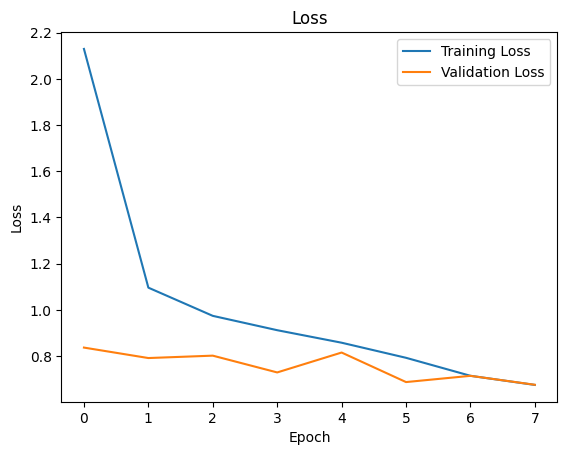

            IoU  Pixel Accuracy  Dice Score
Epoch                                      
0      0.123729        0.627734    0.218165
1      0.258287        0.799338    0.409674
2      0.283883        0.810658    0.441638
3      0.293953        0.816161    0.453521
4      0.306095        0.826104    0.467869
5      0.345232        0.841322    0.512268
6      0.390246        0.864647    0.560667
7      0.421606        0.874521    0.592130


In [131]:
import matplotlib.pyplot as plt
import pandas as pd
# Получение данных обучения из объекта history
loss = history.history['loss']
val_loss = history.history['val_loss']
iou = history.history['iou']
pixel_accuracy = history.history['pixel_accuracy']
dice_score = history.history['dice_score']

# Построение графика функции потерь
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Создание таблицы с метриками
metrics_df = pd.DataFrame({'IoU': iou, 'Pixel Accuracy': pixel_accuracy, 'Dice Score': dice_score})
metrics_df.index.name = 'Epoch'
print(metrics_df)

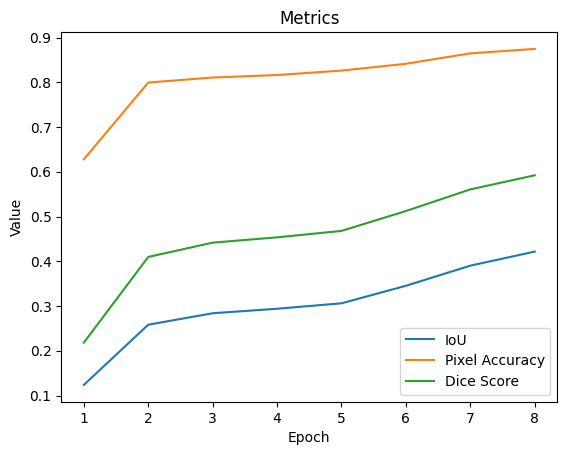

In [134]:
# Построение графика метрик
epochs = range(1, NUM_EPOCHS -1)
plt.plot(epochs, iou, label='IoU')
plt.plot(epochs, pixel_accuracy, label='Pixel Accuracy')
plt.plot(epochs, dice_score, label='Dice Score')
plt.title('Metrics')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
# Создание таблицы с метриками каждые 3 эпохи
metrics_df = pd.DataFrame({'IoU': [], 'Pixel Accuracy': [], 'Dice Score': []})

for epoch in range(0, NUM_EPOCHS, 10):
    metrics_df.loc[epoch] = [iou[epoch], pixel_accuracy[epoch], dice_score[epoch]]

print(metrics_df)

        IoU  Pixel Accuracy  Dice Score
0  0.185532        0.765260    0.312266
3  0.261447        0.813107    0.414303


In [ ]:
# Создание и обучение модели U-Net
model.fit(train_images, train_masks, validation_data=(valid_images, valid_masks), epochs=5, batch_size=16)


Epoch 1/5
23/23 [==============================] - 27s 1s/step - loss: 1.9572 - io_u: 0.4553 - val_loss: 1.3025 - val_io_u: 0.4586
Epoch 2/5
23/23 [==============================] - 27s 1s/step - loss: 1.6492 - io_u: 0.4553 - val_loss: 1.2413 - val_io_u: 0.4586
Epoch 3/5
23/23 [==============================] - 27s 1s/step - loss: 1.4987 - io_u: 0.4553 - val_loss: 1.1955 - val_io_u: 0.4586
Epoch 4/5
23/23 [==============================] - 27s 1s/step - loss: 1.4022 - io_u: 0.4553 - val_loss: 1.1622 - val_io_u: 0.4586
Epoch 5/5
23/23 [==============================] - 28s 1s/step - loss: 1.3388 - io_u: 0.4553 - val_loss: 1.1623 - val_io_u: 0.4586


In [ ]:
# Создание и обучение модели U-Net
model.fit(train_images, train_masks, validation_data=(valid_images, valid_masks), epochs=20, batch_size=16)

Epoch 1/20
23/23 [==============================] - 28s 1s/step - loss: 1.3060 - io_u: 0.4553 - val_loss: 1.1766 - val_io_u: 0.4586
Epoch 2/20
23/23 [==============================] - 27s 1s/step - loss: 1.2869 - io_u: 0.4553 - val_loss: 1.1695 - val_io_u: 0.4586
Epoch 3/20
23/23 [==============================] - 27s 1s/step - loss: 1.2733 - io_u: 0.4553 - val_loss: 1.1476 - val_io_u: 0.4586
Epoch 4/20
23/23 [==============================] - 27s 1s/step - loss: 1.2604 - io_u: 0.4553 - val_loss: 1.1576 - val_io_u: 0.4586
Epoch 5/20
23/23 [==============================] - 27s 1s/step - loss: 1.2512 - io_u: 0.4553 - val_loss: 1.1588 - val_io_u: 0.4586
Epoch 6/20
23/23 [==============================] - 28s 1s/step - loss: 1.2428 - io_u: 0.4553 - val_loss: 1.1433 - val_io_u: 0.4586
Epoch 7/20
23/23 [==============================] - 28s 1s/step - loss: 1.2366 - io_u: 0.4553 - val_loss: 1.1394 - val_io_u: 0.4586
Epoch 8/20
23/23 [==============================] - 28s 1s/step - loss: 1.22

In [ ]:
# Создание и обучение модели U-Net
model.fit(train_images, train_masks, validation_data=(valid_images, valid_masks), epochs=20, batch_size=16)

Epoch 1/20
23/23 [==============================] - 28s 1s/step - loss: 0.9477 - io_u: 0.4553 - val_loss: 1.5060 - val_io_u: 0.4586
Epoch 2/20
23/23 [==============================] - 27s 1s/step - loss: 0.8637 - io_u: 0.4553 - val_loss: 1.3611 - val_io_u: 0.4586
Epoch 3/20
23/23 [==============================] - 27s 1s/step - loss: 0.8248 - io_u: 0.4553 - val_loss: 1.4697 - val_io_u: 0.4586
Epoch 4/20
23/23 [==============================] - 27s 1s/step - loss: 0.7634 - io_u: 0.4554 - val_loss: 2.0517 - val_io_u: 0.4586
Epoch 5/20
23/23 [==============================] - 28s 1s/step - loss: 0.7207 - io_u: 0.4554 - val_loss: 0.9921 - val_io_u: 0.4586
Epoch 6/20
23/23 [==============================] - 28s 1s/step - loss: 0.7070 - io_u: 0.4554 - val_loss: 0.8870 - val_io_u: 0.4586
Epoch 7/20
23/23 [==============================] - 27s 1s/step - loss: 0.6809 - io_u: 0.4555 - val_loss: 1.0162 - val_io_u: 0.4586
Epoch 8/20
23/23 [==============================] - 28s 1s/step - loss: 0.63

In [ ]:
# Создание и обучение модели U-Net
model.fit(train_images, train_masks, validation_data=(valid_images, valid_masks), epochs=20, batch_size=16)

Epoch 1/20
23/23 [==============================] - 27s 1s/step - loss: 0.4753 - io_u: 0.4558 - val_loss: 0.5837 - val_io_u: 0.4586
Epoch 2/20
23/23 [==============================] - 27s 1s/step - loss: 0.4616 - io_u: 0.4561 - val_loss: 0.5500 - val_io_u: 0.4587
Epoch 3/20
23/23 [==============================] - 27s 1s/step - loss: 0.4547 - io_u: 0.4561 - val_loss: 0.5482 - val_io_u: 0.4587
Epoch 4/20
23/23 [==============================] - 28s 1s/step - loss: 0.4503 - io_u: 0.4563 - val_loss: 0.5347 - val_io_u: 0.4587
Epoch 5/20
23/23 [==============================] - 28s 1s/step - loss: 0.4438 - io_u: 0.4565 - val_loss: 0.4850 - val_io_u: 0.4588
Epoch 6/20
23/23 [==============================] - 27s 1s/step - loss: 0.4331 - io_u: 0.4564 - val_loss: 0.4985 - val_io_u: 0.4599
Epoch 7/20
23/23 [==============================] - 28s 1s/step - loss: 0.4289 - io_u: 0.4567 - val_loss: 0.4869 - val_io_u: 0.4599
Epoch 8/20
23/23 [==============================] - 27s 1s/step - loss: 0.42

In [ ]:
tf.saved_model.save(model, 'model')

In [ ]:
result = model.predict(test_images)

4/4 [==============================] - 43s 6s/step


In [ ]:
print(result[0])

[[[0.47826827]
  [0.4567435 ]
  [0.44960868]
  ...
  [0.43913844]
  [0.44659108]
  [0.46055973]]

 [[0.46718577]
  [0.43787858]
  [0.42536798]
  ...
  [0.41276035]
  [0.42190522]
  [0.442816  ]]

 [[0.46031493]
  [0.42663103]
  [0.40714276]
  ...
  [0.39471728]
  [0.40625688]
  [0.43720105]]

 ...

 [[0.46772075]
  [0.44164702]
  [0.42195997]
  ...
  [0.40847135]
  [0.42225954]
  [0.44574282]]

 [[0.4658373 ]
  [0.44093165]
  [0.4232233 ]
  ...
  [0.41868037]
  [0.42743284]
  [0.45218676]]

 [[0.48402107]
  [0.4716454 ]
  [0.4632017 ]
  ...
  [0.46032968]
  [0.4701092 ]
  [0.4765877 ]]]


In [ ]:
from PIL import Image
import numpy as np

# Предположим, что результат предсказания модели содержит вероятности пикселей для каждого класса
# Размерность результатов предсказания: (batch_size, HEIGHT, WIDTH, num_classes)

# Предположим, что результат предсказания модели содержит вероятности пикселей для каждого класса
# Размерность результатов предсказания: (batch_size, HEIGHT, WIDTH, num_classes)
num_classes = 7  # Количество классов (6 классов + 1 класс "ничего")
  # Порог для принятия решения о наличии объекта на пикселе
# Преобразование результатов предсказания в маски с максимальными значениями классов
part = 100
predicted_masks = result[:part]
threshold = 1.5 * np.mean(result)
# true_masks = test_masks
# Создание палитры цветов для каждого класса
palette = [
    (0, 0, 0),  # Класс "ничего" (черный цвет)
    (255, 0, 0),  # Класс 1 (красный цвет)
    (0, 255, 0),  # Класс 2 (зеленый цвет)
    (0, 0, 255),  # Класс 3 (синий цвет)
    (255, 255, 0),  # Класс 4 (желтый цвет)
    (255, 0, 255),  # Класс 5 (пурпурный цвет)
    (0, 255, 255),  # Класс 6 (бирюзовый цвет)
    (255, 255, 255)
]
#
# Создание изображений для каждого предсказанного класса
for i in range(min(predicted_masks.shape[0], part)):
    image = Image.new("RGB",
                      (
                          WIDTH, HEIGHT
                      )
                      )
    true = Image.new("RGB",
                      (
                          WIDTH, HEIGHT
                      )
                      )
    # true_mask = Image.new("RGB",
    #                   (
    #                       WIDTH, HEIGHT
    #                   )
    #                   )
    for y in range(
            HEIGHT
    ):
        for x in range(
                WIDTH
        ):
            if predicted_masks[i][y][x] >= threshold:
                class_index = 7
            else:
                class_index = 0
            # val = predicted_masks[i][x][y]
            image.putpixel((x, y), palette[class_index])  #(int(val * 255), int(val * 255), int(val * 255)))
            val = test_masks[i][y][x]
            true.putpixel((x,y), (int(255 * val), int(255 * val), int(255 * val)))
            # if true_masks[i][y][x] >= threshold:
            #     true_mask.putpixel((x, y), palette[7])
            # else:
            #     true_mask.putpixel((x, y), palette[0])
    image.save(f"result/predicted_image_{i}.png")
    true.save(f"result/predicted_image_{i}_true.png")

    # true_mask.save(f"result_small_5/predicted_image_{i}_true.png")



In [ ]:
print(test_masks[0])